# 01 - Basic GLMs and Inference
The purpose of this file is to:
* Show use-cases for various GLMs
* Introduce the `glm()` function for implementing scalar-response GLMs.
* Work with some inference techniques to ensure we are creating useful models.

In [1]:
library(ggplot2)
options(repr.plot.width = 3, repr.plot.height = 3)

Warning message:
: package 'ggplot2' was built under R version 3.3.3

## Logistic Regression
Recall that in logistic regression, we have a binary response varialbe coded as 0 or 1.  Formally, a logistic regression is parametrized as follows:

$Y_i \sim \text{iid Bin}(1, p_i)$

$g(p_i) = \mathbf{x}_i^\text{T}\beta = \beta_0 + \beta_1 x_i + \cdots + \beta_p x_p$

Where $p_i = p(\mathbf{x}_i)$ depends on the covariates $\mathbf{x}_i$, and $g$ is the _**link function**_.  The two most common logistic links are:

**Logit link:** $g(p) = \log\left(\frac{p}{1-p}\right) = \text{logit}(p)$

**Probit link:** $g(p) = \Phi^{-1}(p)$ (where $\Phi$ is the standard normal cdf.)

### The Data
The data used from this example come from one of UCLA's amazing IDRE modules (for R).  The module can be found [here](https://stats.idre.ucla.edu/r/dae/logit-regression/).

**Data Description:** _A researcher is interested in how variables, such as GRE (Graduate Record Exam scores), GPA (grade point average) and prestige of the undergraduate institution, effect admission into graduate school. The response variable, admit/don’t admit, is a binary variable._

In [2]:
grad <- read.csv("https://stats.idre.ucla.edu/stat/data/binary.csv")

# Let's do some EDA!
print(dim(grad))
head(grad)

[1] 400   4


,admit,gre,gpa,rank
1,0.00,380.00,3.61,3.00
2,1.00,660.00,3.67,3.00
3,1,800,4,1
4,1.00,640.00,3.19,4.00
5,0.00,520.00,2.93,4.00
6,1,760,3,2


In [3]:
summary(grad)

     admit             gre             gpa             rank      
 Min.   :0.0000   Min.   :220.0   Min.   :2.260   Min.   :1.000  
 1st Qu.:0.0000   1st Qu.:520.0   1st Qu.:3.130   1st Qu.:2.000  
 Median :0.0000   Median :580.0   Median :3.395   Median :2.000  
 Mean   :0.3175   Mean   :587.7   Mean   :3.390   Mean   :2.485  
 3rd Qu.:1.0000   3rd Qu.:660.0   3rd Qu.:3.670   3rd Qu.:3.000  
 Max.   :1.0000   Max.   :800.0   Max.   :4.000   Max.   :4.000  

In [4]:
table(grad$admit)


  0   1 
273 127 

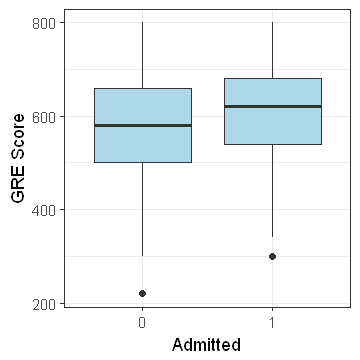

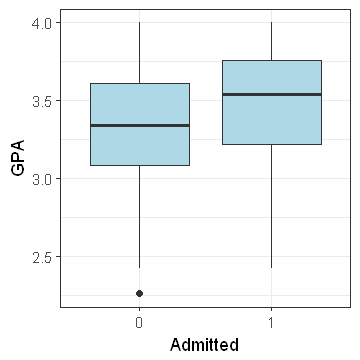

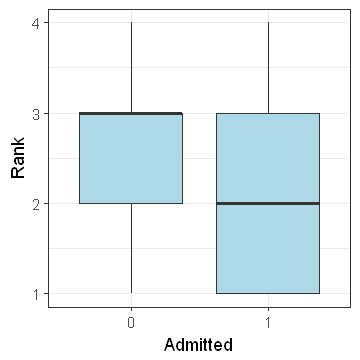

In [5]:
ggplot(grad, aes(as.factor(admit), gre)) +
    theme_bw() +
    geom_boxplot(fill = 'lightblue') +
    labs(x = 'Admitted', y = 'GRE Score')

ggplot(grad, aes(as.factor(admit), gpa)) +
    theme_bw() +
    geom_boxplot(fill = 'lightblue') +
    labs(x = 'Admitted', y = 'GPA')

ggplot(grad, aes(as.factor(admit), rank)) +
    theme_bw() +
    geom_boxplot(fill = 'lightblue') +
    labs(x = 'Admitted', y = 'Rank')

In [6]:
glm_logit <- glm(admit ~ gre + gpa + rank, data = grad, family = binomial)
summary(glm_logit)


Call:
glm(formula = admit ~ gre + gpa + rank, family = binomial, data = grad)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5802  -0.8848  -0.6382   1.1575   2.1732  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -3.449548   1.132846  -3.045  0.00233 ** 
gre          0.002294   0.001092   2.101  0.03564 *  
gpa          0.777014   0.327484   2.373  0.01766 *  
rank        -0.560031   0.127137  -4.405 1.06e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 499.98  on 399  degrees of freedom
Residual deviance: 459.44  on 396  degrees of freedom
AIC: 467.44

Number of Fisher Scoring iterations: 4


### Discussion:
What can you tell me about this output?
* What do the z-statistics tell you?
* If I scored 100 points better on my GRE, how would that affect my odds of acceptance?
* What do you think the number of IRLS interations can tell us?
* Overall, is this a good model fit? (_Without looking at classification accuracy_...)

In [7]:
# Next, let's see if we can safely reduce our model.
glm_reduced <- glm(admit ~ gre + gpa, data = grad, family = binomial)
summary(glm_reduced)


Call:
glm(formula = admit ~ gre + gpa, family = binomial, data = grad)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2730  -0.8988  -0.7206   1.3013   2.0620  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.949378   1.075093  -4.604 4.15e-06 ***
gre          0.002691   0.001057   2.544   0.0109 *  
gpa          0.754687   0.319586   2.361   0.0182 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 499.98  on 399  degrees of freedom
Residual deviance: 480.34  on 397  degrees of freedom
AIC: 486.34

Number of Fisher Scoring iterations: 4


In [8]:
# Test model differences
D <- glm_reduced$deviance - glm_logit$deviance
cat('Difference in Deviance: ', D, '\n')
pval = 1 - pchisq(D, df = 1)
cat('p-value of test of difference: ', pval) # What can we conclude here?

Difference in Deviance:  20.90222 
p-value of test of difference:  4.83335e-06

### Poisson Regression Example
Recall the formal definition of a Poisson regression:

$Y_i \sim \text{iid Poi}(\lambda_i)$

$\log (\lambda_i) = \mathbf{x}_i^\text{T}\beta = \beta_0 + \beta_1 x_1 + \cdots + \beta_p x_p$

where, again, $\lambda_i = \lambda(\mathbf{x}_i)$ depends on $\mathbf{x}_i$.

#### Data
We'll again rely on UCLA's IDRE module.  This one can be found [here](https://stats.idre.ucla.edu/r/dae/poisson-regression/).

#### Data Description
_The number of awards earned by students at one high school. Predictors of the number of awards earned include the type of program in which the student was enrolled (e.g., vocational, general or academic) and the score on their final exam in math._

In [9]:
award = read.csv("https://stats.idre.ucla.edu/stat/data/poisson_sim.csv")

#Let's do some EDA:
head(award)

,id,num_awards,prog,math
1,45,0,3,41
2,108,0,1,41
3,15,0,3,44
4,67,0,3,42
5,153,0,3,40
6,51,0,1,42


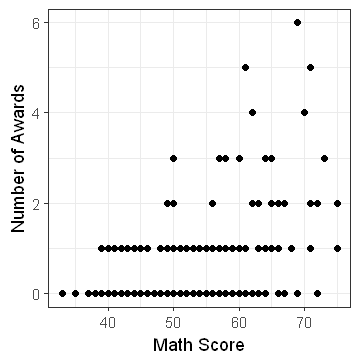

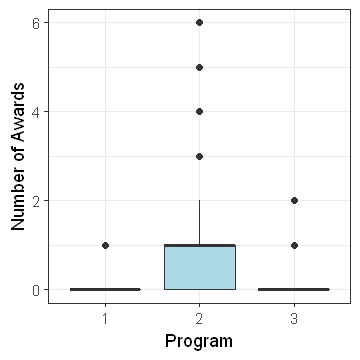

In [10]:
ggplot(award, aes(math, num_awards)) +
    theme_bw() +
    geom_point() +
    labs(x = 'Math Score', y = 'Number of Awards')

ggplot(award, aes(as.factor(prog), num_awards)) +
    theme_bw() +
    geom_boxplot(fill = 'lightblue') +
    labs(x = 'Program', y = 'Number of Awards')

In [11]:
# Notice that prog is actually a categorical variable - I am aware of this.
# I'm going to suspsend that knowledge for the sake of example.
glm_poi <- glm(num_awards ~ prog + math, data = award, family = poisson)
summary(glm_poi)


Call:
glm(formula = num_awards ~ prog + math, family = poisson, data = award)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1840  -0.9003  -0.5891   0.3948   2.9539  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -5.578057   0.676823  -8.242   <2e-16 ***
prog         0.123273   0.163261   0.755     0.45    
math         0.086121   0.009586   8.984   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 287.67  on 199  degrees of freedom
Residual deviance: 203.45  on 197  degrees of freedom
AIC: 385.51

Number of Fisher Scoring iterations: 6


In [12]:
# Interesting - it looks like prog is pretty insignificant.
# Let's try removing it and seeing what happens.
glm_poi_red <- glm(num_awards ~ math, data = award, family = poisson)
summary(glm_poi_red)


Call:
glm(formula = num_awards ~ math, family = poisson, data = award)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.1853  -0.9070  -0.6001   0.3246   2.9529  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -5.333532   0.591261  -9.021   <2e-16 ***
math         0.086166   0.009679   8.902   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 287.67  on 199  degrees of freedom
Residual deviance: 204.02  on 198  degrees of freedom
AIC: 384.08

Number of Fisher Scoring iterations: 6


In [13]:
# Test model difference:
D_poi <- glm_poi_red$deviance - glm_poi$deviance
cat('Difference in Deviance: ', D_poi, '\n')
pval_poi <- 1 - pchisq(D_poi, df = 1)
cat('p-value of test of difference: ', pval_poi)

Difference in Deviance:  0.5701123 
p-value of test of difference:  0.4502143